<a href="https://colab.research.google.com/github/thiagomelostuckert/datathon-fakenews/blob/main/2_Modelos_de_ML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Construção de dois modelos de aprendizado de máquinas que automatizem a detecção de notícias falsas

A etapa seguinte, a ser tocada pelo cientista de dados, envolve o treinamento do modelo. Já tendo em mãos a base de dados de treino preparada pelo analista de dados, o cientista de dados deverá desenvolver pelo menos dois modelos (note que a escolha do modelo pode implicar mudança no tratamento prévio da base de dados), considerando diferentes cenários de inferência.
O cientista de dados deverá considerar dois cenários para inferência para definição dos modelos: batch (quando há uma série de notícias a serem avaliadas simultaneamente) e streaming (uma notícia por vez, em tempo real). Deverá haver justificativa para a escolha de cada modelo para as diferentes finalidades possíveis nas atividades de inteligência, e também devem constar as estatísticas de treino (report de classificação, matriz de confusão, etc.)
Finalmente, o cientista de dados deverá salvar os parâmetros do modelo treinado considerando inferência em streaming no formato ‘pickle’, que será utilizado na próxima etapa.
Recomenda-se utilizar as bibliotecas mais consolidadas para machine learning, como sklearn, tensorflow e pytorch. Não é necessário desenvolver soluções que envolvam poder computacional que exceda a capacidade do Google Colab gratuito.
A avaliação se dará com a performance dos modelos (não disponibilizamos parte da base de dados para verificar o poder de generalização dos modelos); eficiência de código; escolha de cada modelo para qual finalidade.

Importação das bibliotecas

In [148]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import make_pipeline

# Modelos das abordagens clássicas
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier

# Modelo usando rede neural
from sklearn.neural_network import MLPClassifier

# Bibliotecas utilizadas para calcular as métricas dos modelos
from sklearn.metrics import confusion_matrix, accuracy_score, ConfusionMatrixDisplay
from sklearn.metrics import precision_score, f1_score, recall_score, roc_auc_score
from sklearn.metrics import matthews_corrcoef

sns.set()

#Utilizados na hora de carregar o arquivo com a matriz TF-IDF
import gzip
import pickle

Leitura dos arquivos de entrada para os modelos

In [101]:
#Leitura dos textos
url_textos = "https://raw.githubusercontent.com/thiagomelostuckert/datathon-fakenews/main/train_data.csv"
df_textos = pd.read_csv(url_textos, on_bad_lines = 'warn')

In [131]:
# Carrega a matriz TF-IDF calculada anteriormente
!wget "https://github.com/thiagomelostuckert/datathon-fakenews/raw/main/matrix-tf-idf.pkl"

with gzip.open('/content/matrix-tf-idf.pkl', 'rb') as f:
    X = pickle.load(f)

print(X.toarray())
print(X.shape)

--2023-11-25 02:42:01--  https://github.com/thiagomelostuckert/datathon-fakenews/raw/main/matrix-tf-idf.pkl
Resolving github.com (github.com)... 140.82.113.3
Connecting to github.com (github.com)|140.82.113.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/thiagomelostuckert/datathon-fakenews/main/matrix-tf-idf.pkl [following]
--2023-11-25 02:42:01--  https://raw.githubusercontent.com/thiagomelostuckert/datathon-fakenews/main/matrix-tf-idf.pkl
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13076603 (12M) [application/octet-stream]
Saving to: ‘matrix-tf-idf.pkl.1’

matrix-tf-idf.pkl.1 100%[===================>]  12.47M  --.-KB/s    in 0.1s    

2023-11-25 02:42:02 (90.6 MB/s) - ‘matrix-tf-idf.p

In [102]:
#Leitura das classificações
url_classificacoes = "https://raw.githubusercontent.com/thiagomelostuckert/datathon-fakenews/main/train_labels.csv"
df_classificacoes = pd.read_csv(url_classificacoes, on_bad_lines = 'warn')

In [103]:
#Junta os dois datasets em um único dataframe
df = pd.merge(df_textos, df_classificacoes, left_index=True, right_index=True)
df.columns

Index(['preprocessed_news', 'label'], dtype='object')

In [108]:
# Questionar aos organizadores do Datathon se podemos utilizar o arquivo
# pré-processado do repositório do professor como conjunto de dados para testes dos modelos
#Leitura dos textos utilizados no teste
#url_test_data = "https://raw.githubusercontent.com/thiagomelostuckert/datathon-fakenews/main/pre-processed.csv"
#df_test_data = pd.read_csv(url_test_data, on_bad_lines = 'warn')
#df_test_data = df_test_data.drop("index",axis=1)

In [226]:
# Treina o modelo e apresenta suas métricas
# Parâmetro X corresponde aos textos e y às classificações
def fit_and_evaluate_model(model,model_name,X,y):
  # Divide o dataset em treinamento (67%) e teste (33%)
  X_train, X_test, y_train, y_test = train_test_split(
  X, y, test_size=0.33, random_state=42)
  # Treina o modelo com os textos e suas classificações
  model.fit(X_train, y_train)
  #Faz a predição dos textos da base de testes com o modelo Naive Bayes
  predicted_labels = model.predict(X_test)
  # Análise da eficiência do modelo
  # Matriz de confusão
  conf_mat = confusion_matrix(y_test, predicted_labels,labels=["fake","true"],  normalize="true")
  disp = ConfusionMatrixDisplay(confusion_matrix=conf_mat)
  disp.plot()
  plt.show()
  # Imprime outras métricas
  # https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html
  accuracy_value = accuracy_score(y_test, predicted_labels)
  print("Acurácia: {:.3f}".format(accuracy_value))

  #https://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html#sklearn.metrics.f1_score
  f1_value = f1_score(y_test, predicted_labels, average='macro')
  print("F1-Score: {:.3f}".format(f1_value))

  #https://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_score.html#sklearn.metrics.precision_score
  precision_value = precision_score(y_test, predicted_labels, average='macro')
  print("Precisão: {:.3f}".format(precision_value))

  #https://scikit-learn.org/stable/modules/generated/sklearn.metrics.recall_score.html
  recall_value = recall_score(y_test, predicted_labels, average='macro')
  print("Cobertura (recall): {:.3f}".format(recall_value))

  evalution_metric = {"Model":model_name, "ACC":accuracy_value, "F1":f1_value, "PRE":precision_value,
          "REC":recall_value}

  return evalution_metric


Significado das células da matriz de confusão

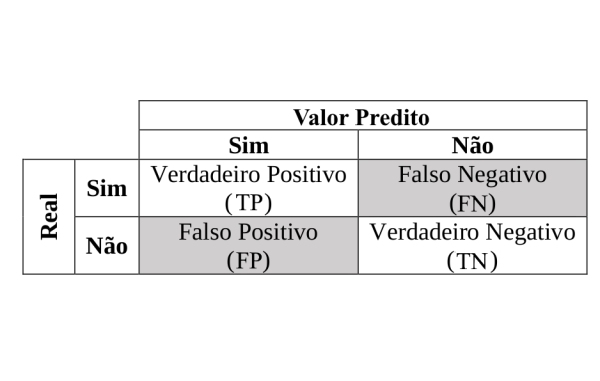

In [227]:
# Lista utilizada para armazenar as métricas obtidas em cada classificador
evaluation_metrics = []

### Abordagens clássicas

Naive Bayes

Referências:
https://www.turing.com/kb/document-classification-using-naive-bayes

https://towardsdatascience.com/implementing-a-naive-bayes-classifier-for-text-categorization-in-five-steps-f9192cdd54c3

MultinomialNB é um classificador Naive Bayes
https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html



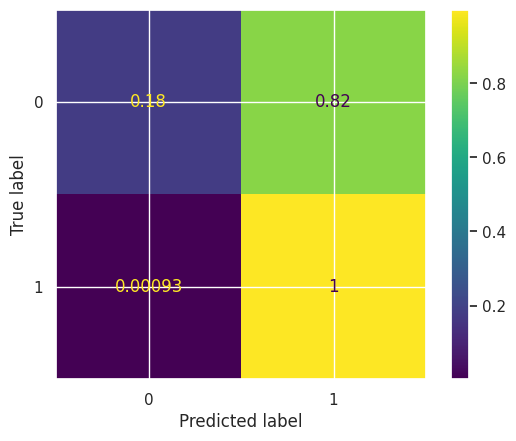

Acurácia: 0.589
F1-Score: 0.505
Precisão: 0.772
Cobertura (recall): 0.588


In [228]:
# Construção de uma modelo clássico usando Naive Bayes
# Utilizando a matriz TF-IDF calculada anteriormente
model = make_pipeline(MultinomialNB())
model_name="NB"
evaluation_metric = fit_and_evaluate_model(model,model_name,X, df.label)
evaluation_metrics.append(evaluation_metric)

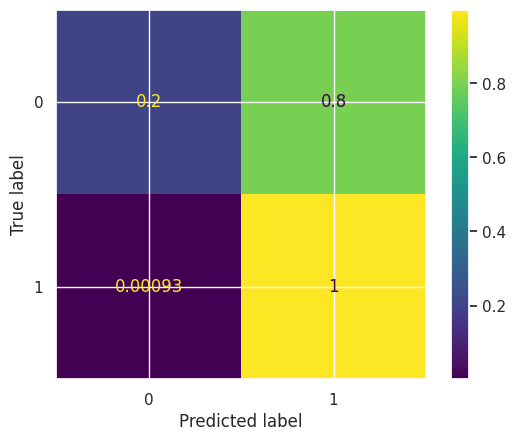

Acurácia: 0.602
F1-Score: 0.528
Precisão: 0.776
Cobertura (recall): 0.602


In [229]:
# Construção de uma modelo clássico usando Naive Bayes
# Calculando a matriz TF-IDF durante o pipeline do modelo
model = make_pipeline(TfidfVectorizer(), MultinomialNB())
model_name="NB"
evaluation_metric = fit_and_evaluate_model(model,model_name, df.preprocessed_news, df.label)
evaluation_metrics.append(evaluation_metric)

Regressão logística

Referências: https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html
*italicized text*

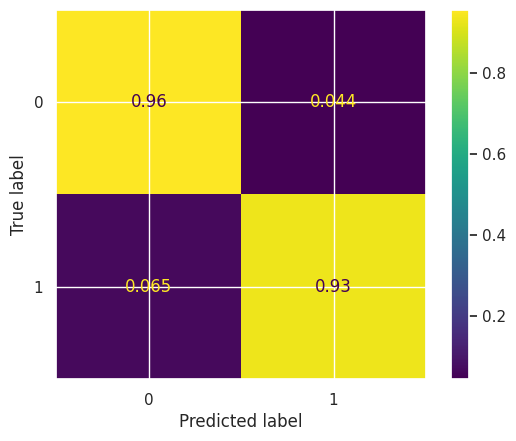

Acurácia: 0.945
F1-Score: 0.945
Precisão: 0.946
Cobertura (recall): 0.945


In [230]:
# Construção de uma modelo clássico usando Regressão logística
model = make_pipeline(TfidfVectorizer(), LogisticRegression())
model_name="LR"
evaluation_metric = fit_and_evaluate_model(model,model_name,df.preprocessed_news, df.label)
evaluation_metrics.append(evaluation_metric)

Linear Support Vector Classification

Referências:
https://scikit-learn.org/stable/modules/generated/sklearn.svm.LinearSVC.html


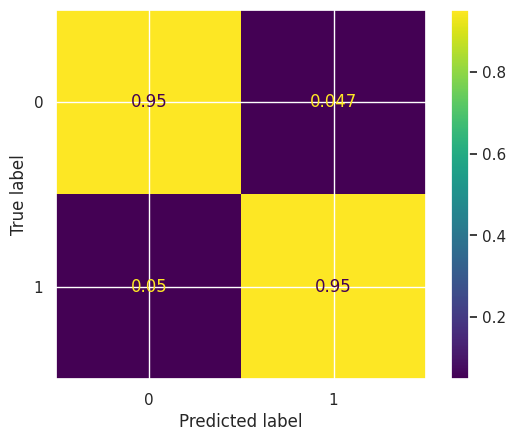

Acurácia: 0.952
F1-Score: 0.952
Precisão: 0.952
Cobertura (recall): 0.952


In [231]:
# Construção de uma modelo clássico usando Linear Support Vector Classification
model = make_pipeline(TfidfVectorizer(), LinearSVC())
model_name = "SVC"
evaluation_metric = fit_and_evaluate_model(model,model_name,df.preprocessed_news, df.label)
evaluation_metrics.append(evaluation_metric)

A random forest classifier.

Referências: https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html



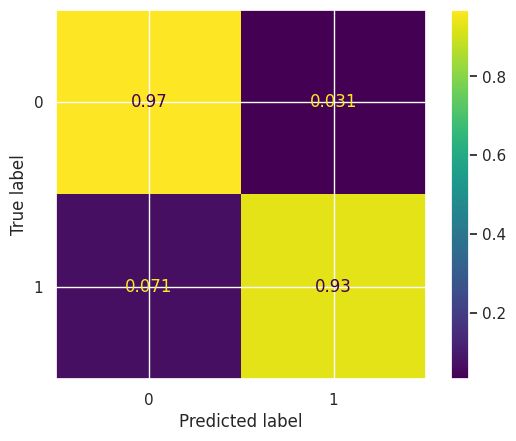

Acurácia: 0.949
F1-Score: 0.949
Precisão: 0.950
Cobertura (recall): 0.949


In [232]:
# Construção de uma modelo clássico usando RandomForestClassifier
model = make_pipeline(TfidfVectorizer(), RandomForestClassifier())
model_name = "RFC"
evaluation_metric = fit_and_evaluate_model(model,model_name, df.preprocessed_news, df.label)
evaluation_metrics.append(evaluation_metric)

In [233]:
# Imprime as métricas das abordagens clássicas para facilitar a comparação
print()
for key in evaluation_metrics[0].keys():
  print(key,end='\t')

print()
for evaluation_metric in evaluation_metrics:
  for key, value in evaluation_metric.items():
    if type(value) == str:
      print(value,end='\t')
    else:
      print("{:.3f}".format(value),end='\t')
  print()


Model	ACC	F1	PRE	REC	
NB	0.589	0.505	0.772	0.588	
NB	0.602	0.528	0.776	0.602	
LR	0.945	0.945	0.946	0.945	
SVC	0.952	0.952	0.952	0.952	
RFC	0.949	0.949	0.950	0.949	


# Abordagem usando rede neural
Multi-layer Perceptron classifier

Referências: https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html


In [ ]:
%time
# Atenção essa célula demora para rodar
# Construção de uma modelo clássico usando Multi-layer Perceptron classifier
model = make_pipeline(TfidfVectorizer(), MLPClassifier())
model_name = "MLP"
fit_and_evaluate_model(model,model_name,df.preprocessed_news, df.label)
evaluation_metrics.append(evaluation_metric)

CPU times: user 1e+03 ns, sys: 1e+03 ns, total: 2 µs
Wall time: 5.48 µs


In [ ]:
# Imprime as métricas dos classificadores
print()
for key in evaluation_metrics[0].keys():
  print(key,end='\t')

print()
for evaluation_metric in evaluation_metrics:
  for key, value in evaluation_metric.items():
    if type(value) == str:
      print(value,end='\t')
    else:
      print("{:.3f}".format(value),end='\t')
  print()

Modelo Batch (quando há uma série de notícias a serem avaliadas simultaneamente)

Model streaming (uma notícia por vez, em tempo real)

Salvar os parâmetros do modelo treinado considerando inferência em streaming no formato ‘pickle’